## Working With Drug Data From the ChEMBL Database

When working on drug discovery projects, it's handy to have access to a set of chemical structures and associated data for marketed drugs. If you're considering introducing new functionality, someone invariably asks whether that functionality has been used in a marketed drug. It's also helpful to compare the properties of a new compound or compounds to those of marketed drugs. Early in my career, I remember a new medicinal chemist asking Josh Boger, the founder of Vertex Pharmaceuticals, what they should do on their first day of work. Boger responded, "read the Merck Index so you can see what a drug is supposed to look like". Recently a few papers have been published showing how the properties of drugs have changed over time. I thought it might be helpful to create a notebook showing how to extract and clean drug data from ChEMBL and use it for subsequent analysis.

In [ ]:
!pip install pandas rdkit tqdm useful_rdkit_utils seaborn scikit-posthocs chembl_downloader

In [1]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.rdBase import BlockLogs
from tqdm.auto import tqdm
import re
import useful_rdkit_utils as uru
from rdkit.Chem.Draw import MolsToGridImage
import seaborn as sns
import scikit_posthocs as sp
import chembl_downloader

### Overview

In this notebook we'll perform the following steps.

1. Download ChEMBL database
2. Query ChEMBL for drug data
3. Remove duplicates from the ChEMBL data 
4. Divide the ChEMBL data into three groups based on the first approval date, before 1997, 1997-2017, after 2017
5. Compare the molecular weight and calculated logp distributions for the three groups and determine if the differences between groups are statistically significant. 

Enable progress bars in Pandas

In [2]:
tqdm.pandas()

### 1. Download the ChEMBL database

We begin by using the awesome [ChEMBL downloader](https://github.com/cthoyt/chembl-downloader) by Charles Tapley Hoyt to download the latest version of the ChEMBL database.  On my laptop, this took 7 minutes and consumed 27GB of disk space. The ChEMBL downloader not only makes it easy to download the database, it also allows you to submit queries and returns the results as a Pandas dataframe. 

In [3]:
path = chembl_downloader.download_extract_sqlite()

In [4]:
path

PosixPath('/Users/pwalters/.data/chembl/32/data/chembl_32/chembl_32_sqlite/chembl_32.db')

### 2. Query ChEMBL for drug data

Define an SQL query to grab the drug data from ChEMBL

In [5]:
sql = """
select cs.canonical_smiles, cs.molregno, pref_name, first_approval, dosed_ingredient, oral, parenteral, topical,
       black_box_warning, first_in_class from molecule_dictionary md
join compound_structures cs on cs.molregno = md.molregno
join compound_properties cp on md.molregno = cp.molregno
where max_phase = 4 and molecule_type = 'Small molecule'
and cp.full_mwt > 200 and cp.full_mwt < 1000
group by cs.canonical_smiles, cs.molregno
"""

In [6]:
df = chembl_downloader.query(sql)

In [7]:
df

,canonical_smiles,molregno,pref_name,first_approval,dosed_ingredient,oral,parenteral,topical,black_box_warning,first_in_class
0,Br.CC(N)Cc1ccc(O)cc1,674656,HYDROXYAMPHETAMINE HYDROBROMIDE,1969.0,1,0,0,1,0,0
1,Br.CC(NC(C)(C)C)C(=O)c1cccc(Cl)c1,675686,BUPROPION HYDROBROMIDE,2008.0,1,1,0,0,1,0
2,Br.CC1C2Cc3ccc(O)cc3C1(C)CCN2CCc1ccccc1,1379567,PHENAZOCINE HYDROBROMIDE,NaN,1,0,0,0,0,0
3,Br.CCN(c1cc(-c2ccc(CN3CCOCC3)cc2)cc(C(=O)NCc2c...,2464691,TAZEMETOSTAT HYDROBROMIDE,2020.0,1,1,0,0,0,1
4,Br.CN(C)CCCC1(c2ccc(F)cc2)OCc2cc(C#N)ccc21,674732,CITALOPRAM HYDROBROMIDE,1998.0,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
2912,c1ccc2c(CCC3CCNCC3)c[nH]c2c1,16580,INDALPINE,NaN,1,0,0,0,0,0
2913,c1ccc2c(c1)CCCC2C1=NCCN1,245084,TETRAHYDROZOLINE,1979.0,0,0,0,1,0,0
2914,c1ccc2c(c1)Sc1ccccc1N2CC1CN2CCC1CC2,112175,MEQUITAZINE,NaN,1,0,0,0,0,0
2915,c1cnc(N2CCN(Cc3ccc4c(c3)OCO4)CC2)nc1,795654,PIRIBEDIL,NaN,1,0,0,0,0,0


### 3. Remove duplicates from the ChEMBL data

Several drugs are in ChEMBL multiple times as different salt forms.  To simplify our analysis, we'd like to only have each drug represented once.  We can use the MolStandardize functionality in the RDKit to remove salts and add another column with the standardized SMILES (std_smiles).  I used the example code below from the bitsilla blog to standardize the SMILES. 

In [8]:
# Borrowed from https://bitsilla.com/blog/2021/06/standardizing-a-molecule-using-rdkit/
def standardize(smiles):
    # follows the steps in
    # https://github.com/greglandrum/RSC_OpenScience_Standardization_202104/blob/main/MolStandardize%20pieces.ipynb
    # as described **excellently** (by Greg) in
    # https://www.youtube.com/watch?v=eWTApNX8dJQ
    mol = Chem.MolFromSmiles(smiles)
     
    # removeHs, disconnect metal atoms, normalize the molecule, reionize the molecule
    clean_mol = rdMolStandardize.Cleanup(mol) 
     
    # if many fragments, get the "parent" (the actual mol we are interested in) 
    parent_clean_mol = rdMolStandardize.FragmentParent(clean_mol)
         
    # try to neutralize molecule
    uncharger = rdMolStandardize.Uncharger() # annoying, but necessary as no convenience method exists
    uncharged_parent_clean_mol = uncharger.uncharge(parent_clean_mol)
     
    # note that no attempt is made at reionization at this step
    # nor at ionization at some pH (rdkit has no pKa caculator)
    # the main aim to to represent all molecules from different sources
    # in a (single) standard way, for use in ML, catalogue, etc.
     
    te = rdMolStandardize.TautomerEnumerator() # idem
    taut_uncharged_parent_clean_mol = te.Canonicalize(uncharged_parent_clean_mol)
     
    return Chem.MolToSmiles(taut_uncharged_parent_clean_mol)

The code below performs the standardization and creates a new column.  Note the use of [BlockLogs](https://rdkit.org/docs/source/rdkit.rdBase.html).  The standardizer has a lot of logging messages that I prefer to ignore.   

In [9]:
with BlockLogs():
    df['std_smiles'] = df.canonical_smiles.progress_apply(standardize)

  0%|          | 0/2917 [00:00<?, ?it/s]

Drop any rows that don't have a first_approval year. 

In [10]:
df_ok = df.dropna(subset="first_approval").copy()

The **first_approval** field comes over from ChEMBL as a floating point number.  This bugs me so I'll convert it to an integer. 

In [11]:
df_ok.first_approval = df_ok.first_approval.astype(int)
df_ok

,canonical_smiles,molregno,pref_name,first_approval,dosed_ingredient,oral,parenteral,topical,black_box_warning,first_in_class,std_smiles
0,Br.CC(N)Cc1ccc(O)cc1,674656,HYDROXYAMPHETAMINE HYDROBROMIDE,1969,1,0,0,1,0,0,CC(N)Cc1ccc(O)cc1
1,Br.CC(NC(C)(C)C)C(=O)c1cccc(Cl)c1,675686,BUPROPION HYDROBROMIDE,2008,1,1,0,0,1,0,CC(NC(C)(C)C)C(=O)c1cccc(Cl)c1
3,Br.CCN(c1cc(-c2ccc(CN3CCOCC3)cc2)cc(C(=O)NCc2c...,2464691,TAZEMETOSTAT HYDROBROMIDE,2020,1,1,0,0,0,1,CCN(c1cc(-c2ccc(CN3CCOCC3)cc2)cc(C(=O)NCc2c(C)...
4,Br.CN(C)CCCC1(c2ccc(F)cc2)OCc2cc(C#N)ccc21,674732,CITALOPRAM HYDROBROMIDE,1998,1,1,0,0,1,0,CN(C)CCCC1(c2ccc(F)cc2)OCc2cc(C#N)ccc21
5,Br.CN1CCC[C@@H]1Cc1c[nH]c2ccc(CCS(=O)(=O)c3ccc...,674954,ELETRIPTAN HYDROBROMIDE,2002,1,1,0,0,0,0,CN1CCC[C@@H]1Cc1c[nH]c2ccc(CCS(=O)(=O)c3ccccc3...
...,...,...,...,...,...,...,...,...,...,...,...
2909,c1ccc([C@H]2CN3CCSC3=N2)cc1,384948,LEVAMISOLE,1990,0,1,0,0,0,0,c1ccc([C@H]2CN3CCSC3=N2)cc1
2910,c1ccc2[nH]c(-c3cscn3)nc2c1,26590,THIABENDAZOLE,1967,1,1,0,0,0,0,c1ccc2[nH]c(-c3cscn3)nc2c1
2911,c1ccc2c(CC3=NCCN3)cccc2c1,42468,NAPHAZOLINE,1971,0,0,0,1,0,0,c1ccc2c(CC3=NCCN3)cccc2c1
2913,c1ccc2c(c1)CCCC2C1=NCCN1,245084,TETRAHYDROZOLINE,1979,0,0,0,1,0,0,c1ccc2c(c1)CCCC2C1=NCCN1


Let's take a look a structures that occur multiple times.  The first one is citrate. This is an odd case where we have things like sodium citrate where the salt is larger than the parent.  There aren't a lot of these and I don't find them interesting so I'm ignoring them.  The second example, which occurs six times is more interesting. 

In [12]:
df_freq = uru.value_counts_df(df_ok,"std_smiles")
df_freq

,std_smiles,count
0,O=C(O)CC(O)(CC(=O)O)C(=O)O,7
1,CC1(C)S[C@@H]2C(NC(=O)Cc3ccccc3)C(=O)N2C1C(=O)O,6
2,CC(N)Cc1ccccc1,5
3,COCCc1ccc(OCC(O)CNC(C)C)cc1,4
4,O=C(O)CN(CCN(CC(=O)O)CC(=O)O)CC(=O)O,4
...,...,...
1539,CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]...,1
1540,CC[N+](C)(C)c1cccc(O)c1,1
1541,CCc1cc(/C(C)=N/OCc2ccc(C3CCCCC3)c(C(F)(F)F)c2)...,1
1542,CCc1cccc2c3c([nH]c12)C(CC)(CC(=O)O)OCC3,1


If we take a look at this one, we see various forms of penicillin.

In [13]:
query_smi = df_freq.std_smiles.values[1]
print(query_smi)
df_ok.query("std_smiles == @query_smi").sort_values("first_approval")

CC1(C)S[C@@H]2C(NC(=O)Cc3ccccc3)C(=O)N2C1C(=O)O


,canonical_smiles,molregno,pref_name,first_approval,dosed_ingredient,oral,parenteral,topical,black_box_warning,first_in_class,std_smiles
569,CC1(C)S[C@@H]2[C@H](NC(=O)Cc3ccccc3)C(=O)N2[C@...,1615,BENZYLPENICILLIN,1947,1,1,1,0,1,0,CC1(C)S[C@@H]2C(NC(=O)Cc3ccccc3)C(=O)N2C1C(=O)O
574,CC1(C)S[C@@H]2[C@H](NC(=O)Cc3ccccc3)C(=O)N2[C@...,226400,PENICILLIN G POTASSIUM,1947,1,1,1,0,0,0,CC1(C)S[C@@H]2C(NC(=O)Cc3ccccc3)C(=O)N2C1C(=O)O
571,CC1(C)S[C@@H]2[C@H](NC(=O)Cc3ccccc3)C(=O)N2[C@...,1051276,PROCAINE BENZYLPENICILLIN,1948,1,0,1,0,0,0,CC1(C)S[C@@H]2C(NC(=O)Cc3ccccc3)C(=O)N2C1C(=O)O
572,CC1(C)S[C@@H]2[C@H](NC(=O)Cc3ccccc3)C(=O)N2[C@...,674887,PENICILLIN G PROCAINE,1948,1,0,1,0,0,0,CC1(C)S[C@@H]2C(NC(=O)Cc3ccccc3)C(=O)N2C1C(=O)O
570,CC1(C)S[C@@H]2[C@H](NC(=O)Cc3ccccc3)C(=O)N2[C@...,2197386,PENICILLIN G BENZATHINE,1952,1,1,1,0,1,0,CC1(C)S[C@@H]2C(NC(=O)Cc3ccccc3)C(=O)N2C1C(=O)O
575,CC1(C)S[C@@H]2[C@H](NC(=O)Cc3ccccc3)C(=O)N2[C@...,167260,PENICILLIN G SODIUM,1988,1,0,1,0,0,0,CC1(C)S[C@@H]2C(NC(=O)Cc3ccccc3)C(=O)N2C1C(=O)O


Now let's remove the duplicate structures. To do this, we sort by **first_approval** then remove duplicate **std_smiles**"

In [14]:
df_ok_nodupe = df_ok.sort_values("first_approval").drop_duplicates("std_smiles").copy()
len(df_ok),len(df_ok_nodupe)

(2314, 1544)

Next, let's limit our analysis to oral drugs. 

In [15]:
df_oral_ok_nodupe = df_ok_nodupe.query("oral == 1").copy()
len(df_oral_ok_nodupe)

1032

There still may be duplicates that are the same structure with different charge states.  One way to handle this is to generate an InChI for each structure and remove the charge layer.  In this way, the charged and uncharged versions will have the same InChI string. 

Define a function to generate an InChI without the charge field.  This is a bit of a hack.  I should probably be passing the "nochg" option to Chem.MolToInchi but I can't figure out how to do that. 

In [16]:
def smi_to_inchi_nochg(smi):
    mol = Chem.MolFromSmiles(smi)
    inchi = Chem.MolToInchi(mol)
    return re.sub("\/p\+[0-9]+","",inchi)

To test our function we'll generate InChi strings for the neutral and protonated forms of propylamine.  We can then check to see if the InChi strings are the same.  

In [17]:
no_chg_inchi = smi_to_inchi_nochg("CCCN")
chg_inchi = smi_to_inchi_nochg("CCC[NH3+]")
no_chg_inchi, chg_inchi, chg_inchi==no_chg_inchi

[15:47:02] WARNING: Proton(s) added/removed



('InChI=1S/C3H9N/c1-2-3-4/h2-4H2,1H3',
 'InChI=1S/C3H9N/c1-2-3-4/h2-4H2,1H3',
 True)

Now we'll apply this function to all of the structures in our dataframe. As above, I'm using **BlockLogs** to ignore the logging messages. 

In [18]:
with BlockLogs():
    df_oral_ok_nodupe['inchi'] = df_oral_ok_nodupe.std_smiles.apply(smi_to_inchi_nochg)

Let's see if we have any InChI duplicates.  We can use the function **value_counts_df** from the useful_rdkit_utils package to convert the results of the Pandas value_counts method to a nicely formatted dataframe.  It looks like there's only one example with two different charge states. 

In [19]:
df_dupe_inchi = uru.value_counts_df(df_oral_ok_nodupe,"inchi")
df_dupe_inchi

,inchi,count
0,InChI=1S/C31H35F6N4O5P/c1-20-8-6-7-9-24(20)25-...,2
1,"InChI=1S/C11H11N3O2S/c12-9-4-6-10(7-5-9)17(15,...",1
2,InChI=1S/C24H21F2NO3/c25-17-5-1-15(2-6-17)22(2...,1
3,InChI=1S/C20H21FN2O/c1-23(2)11-3-10-20(17-5-7-...,1
4,InChI=1S/C23H34O5/c1-2-3-4-7-17(24)9-10-18-19-...,1
...,...,...
1026,InChI=1S/C25H32O2/c1-3-25(26)15-13-23-22-10-8-...,1
1027,InChI=1S/C22H22N2O8/c1-7-8-5-4-6-9(25)11(8)16(...,1
1028,InChI=1S/C20H23NS/c1-21-12-6-7-15(14-21)13-18-...,1
1029,InChI=1S/C19H23NO/c1-20-14-12-18(13-15-20)21-1...,1


Let's take a closer look at this example.

In [20]:
inchi_val = df_dupe_inchi.inchi.values[0]
dupe_inchi_df = df_oral_ok_nodupe.query("inchi == @inchi_val")
dupe_inchi_df

,canonical_smiles,molregno,pref_name,first_approval,dosed_ingredient,oral,parenteral,topical,black_box_warning,first_in_class,std_smiles,inchi
2210,Cc1ccccc1-c1cc(N2CC[N+](C)(COP(=O)(O)O)CC2)ncc...,2197790,FOSNETUPITANT CHLORIDE HYDROCHLORIDE,2018,1,1,1,0,0,0,Cc1ccccc1-c1cc(N2CC[N+](C)(COP(=O)(O)O)CC2)ncc...,InChI=1S/C31H35F6N4O5P/c1-20-8-6-7-9-24(20)25-...
2211,Cc1ccccc1-c1cc(N2CC[N+](C)(COP(=O)([O-])O)CC2)...,2197788,FOSNETUPITANT,2018,0,1,1,0,0,0,Cc1ccccc1-c1cc(N2CC[N+](C)(COP(=O)([O-])O)CC2)...,InChI=1S/C31H35F6N4O5P/c1-20-8-6-7-9-24(20)25-...


In [21]:
dupe_inchi_df.std_smiles.values

array(['Cc1ccccc1-c1cc(N2CC[N+](C)(COP(=O)(O)O)CC2)ncc1N(C)C(=O)C(C)(C)c1cc(C(F)(F)F)cc(C(F)(F)F)c1',
       'Cc1ccccc1-c1cc(N2CC[N+](C)(COP(=O)([O-])O)CC2)ncc1N(C)C(=O)C(C)(C)c1cc(C(F)(F)F)cc(C(F)(F)F)c1'],
      dtype=object)

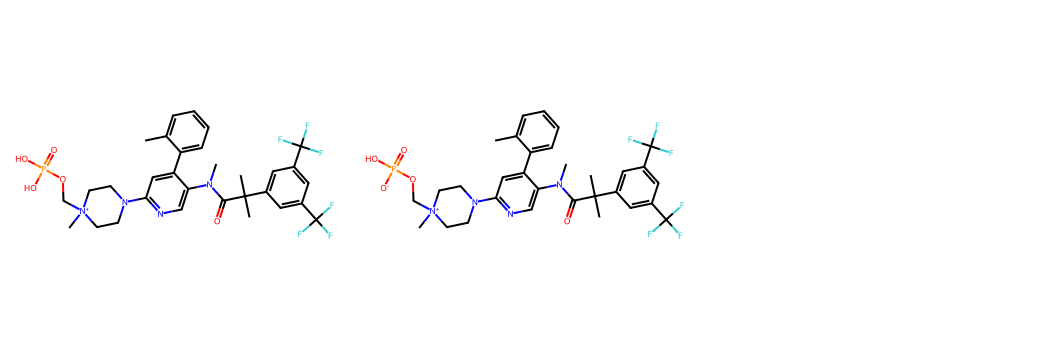

In [22]:
dupe_mol_list = [Chem.MolFromSmiles(x) for x in dupe_inchi_df.std_smiles]
MolsToGridImage(dupe_mol_list,useSVG=True,subImgSize=(350,350))

In order to clean things up a bit, we can drop the duplicate record. 

In [23]:
df_final_drug = df_oral_ok_nodupe.sort_values("first_approval").drop_duplicates("inchi").copy()
len(df_final_drug)

1031

### 4. Divide the ChEMBL data into three groups, before 1997, 1997-2017, after 2017

Now that we have a clean datset, we can do some analysis.  We'll start dividing the data into three sets based on the first approval year.  To do this we'll use the criteria defined in a 2023 paper by XXXXX. Note how the Pandas cut function makes it easy to bin the data. 

In [24]:
df_final_drug['era'] = pd.cut(df_final_drug.first_approval,[0,1996,2017,5000],labels=["before 1997","1997-2017","after 2017"])

In [25]:
df_final_drug

,canonical_smiles,molregno,pref_name,first_approval,dosed_ingredient,oral,parenteral,topical,black_box_warning,first_in_class,std_smiles,inchi,era
2549,Nc1ccc(S(=O)(=O)Nc2ccccn2)cc1,32842,SULFAPYRIDINE,1939,1,1,0,0,0,0,Nc1ccc(S(=O)(=O)Nc2ccccn2)cc1,"InChI=1S/C11H11N3O2S/c12-9-4-6-10(7-5-9)17(15,...",before 1997
667,CCC(C)C1(CC)C(=O)NC(=O)NC1=O,2393,BUTABARBITAL,1939,0,1,0,0,0,0,CCC(C)C1(CC)C(=O)NC(=O)NC1=O,InChI=1S/C10H16N2O3/c1-4-6(3)10(5-2)7(13)11-9(...,before 1997
2370,Cn1c(=O)c2[nH]cnc2n(C)c1=O.Cn1c(=O)c2[nH]cnc2n...,794445,AMINOPHYLLINE,1940,1,1,1,1,0,0,Cn1c(=O)c2[nH]cnc2n(C)c1=O,InChI=1S/C7H8N4O2/c1-10-5-4(8-3-9-5)6(12)11(2)...,before 1997
2551,Nc1ccc(S(=O)(=O)Nc2ncccn2)cc1,2131,SULFADIAZINE,1941,1,1,1,1,0,0,Nc1ccc(S(=O)(=O)Nc2ncccn2)cc1,"InChI=1S/C10H10N4O2S/c11-8-2-4-9(5-3-8)17(15,1...",before 1997
73,C=C1CC[C@H](O)C/C1=C/C=C1\CCC[C@]2(C)[C@@H]([C...,430124,ERGOCALCIFEROL,1941,1,1,1,0,0,0,C=C1CC[C@H](O)C/C1=C/C=C1\CCC[C@]2(C)[C@@H]([C...,InChI=1S/C28H44O/c1-19(2)20(3)9-10-22(5)26-15-...,before 1997
...,...,...,...,...,...,...,...,...,...,...,...,...,...
888,CCCS(=O)(=O)N[C@H]1C[C@@H](N(C)c2ncnc3[nH]ccc2...,1987927,ABROCITINIB,2022,1,1,0,0,1,0,CCCS(=O)(=O)N[C@H]1C[C@@H](N(C)c2ncnc3[nH]ccc2...,"InChI=1S/C14H21N5O2S/c1-3-6-22(20,21)18-10-7-1...",after 2017
2902,[2H]C([2H])([2H])NC(=O)c1nnc(NC(=O)C2CC2)cc1Nc...,2342179,DEUCRAVACITINIB,2022,1,1,0,0,0,0,[2H]C([2H])([2H])NC(=O)c1nnc(NC(=O)C2CC2)cc1Nc...,InChI=1S/C20H22N8O3/c1-21-20(30)16-14(9-15(25-...,after 2017
1488,CNC(=O)c1nnc(NC(=O)C2CC2)cc1Nc1cccc(-c2ncn(C)n...,2466823,DEUCRAVACITINIB,2022,0,1,0,0,0,0,CNC(=O)c1nnc(NC(=O)C2CC2)cc1Nc1cccc(-c2ncn(C)n...,InChI=1S/C20H22N8O3/c1-21-20(30)16-14(9-15(25-...,after 2017
1521,CNCc1cc(-c2ccccc2F)n(S(=O)(=O)c2cccnc2)c1,1363360,VONOPRAZAN,2022,0,1,0,0,0,0,CNCc1cc(-c2ccccc2F)n(S(=O)(=O)c2cccnc2)c1,InChI=1S/C17H16FN3O2S/c1-19-10-13-9-17(15-6-2-...,after 2017


### 5. Compare the molecular weight and calculated logp distributions for the three groups, and determine if the differences between groups are statistically significant.
Now let's calculate the parameters the define Lipinski's Rule of 5.  Fortunately, the useful_rdkit_utils package has a convenience function to make this easy. 

In [26]:
ro5_calc = uru.Ro5Calculator()
df_final_drug[ro5_calc.names] = df_final_drug.std_smiles.apply(ro5_calc.calc_smiles).tolist()

In [27]:
df_final_drug

,canonical_smiles,molregno,pref_name,first_approval,dosed_ingredient,oral,parenteral,topical,black_box_warning,first_in_class,std_smiles,inchi,era,MolWt,LogP,HBD,HBA,TPSA
2549,Nc1ccc(S(=O)(=O)Nc2ccccn2)cc1,32842,SULFAPYRIDINE,1939,1,1,0,0,0,0,Nc1ccc(S(=O)(=O)Nc2ccccn2)cc1,"InChI=1S/C11H11N3O2S/c12-9-4-6-10(7-5-9)17(15,...",before 1997,249.295000,1.4646,2.0,4.0,85.08
667,CCC(C)C1(CC)C(=O)NC(=O)NC1=O,2393,BUTABARBITAL,1939,0,1,0,0,0,0,CCC(C)C1(CC)C(=O)NC(=O)NC1=O,InChI=1S/C10H16N2O3/c1-4-6(3)10(5-2)7(13)11-9(...,before 1997,212.249000,0.7949,2.0,3.0,75.27
2370,Cn1c(=O)c2[nH]cnc2n(C)c1=O.Cn1c(=O)c2[nH]cnc2n...,794445,AMINOPHYLLINE,1940,1,1,1,1,0,0,Cn1c(=O)c2[nH]cnc2n(C)c1=O,InChI=1S/C7H8N4O2/c1-10-5-4(8-3-9-5)6(12)11(2)...,before 1997,180.167000,-1.0397,1.0,5.0,72.68
2551,Nc1ccc(S(=O)(=O)Nc2ncccn2)cc1,2131,SULFADIAZINE,1941,1,1,1,1,0,0,Nc1ccc(S(=O)(=O)Nc2ncccn2)cc1,"InChI=1S/C10H10N4O2S/c11-8-2-4-9(5-3-8)17(15,1...",before 1997,250.283000,0.8596,2.0,5.0,97.97
73,C=C1CC[C@H](O)C/C1=C/C=C1\CCC[C@]2(C)[C@@H]([C...,430124,ERGOCALCIFEROL,1941,1,1,1,0,0,0,C=C1CC[C@H](O)C/C1=C/C=C1\CCC[C@]2(C)[C@@H]([C...,InChI=1S/C28H44O/c1-19(2)20(3)9-10-22(5)26-15-...,before 1997,396.659000,7.6410,1.0,1.0,20.23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
888,CCCS(=O)(=O)N[C@H]1C[C@@H](N(C)c2ncnc3[nH]ccc2...,1987927,ABROCITINIB,2022,1,1,0,0,1,0,CCCS(=O)(=O)N[C@H]1C[C@@H](N(C)c2ncnc3[nH]ccc2...,"InChI=1S/C14H21N5O2S/c1-3-6-22(20,21)18-10-7-1...",after 2017,323.422000,1.2545,2.0,5.0,90.98
2902,[2H]C([2H])([2H])NC(=O)c1nnc(NC(=O)C2CC2)cc1Nc...,2342179,DEUCRAVACITINIB,2022,1,1,0,0,0,0,[2H]C([2H])([2H])NC(=O)c1nnc(NC(=O)C2CC2)cc1Nc...,InChI=1S/C20H22N8O3/c1-21-20(30)16-14(9-15(25-...,after 2017,425.467305,1.7324,3.0,9.0,135.95
1488,CNC(=O)c1nnc(NC(=O)C2CC2)cc1Nc1cccc(-c2ncn(C)n...,2466823,DEUCRAVACITINIB,2022,0,1,0,0,0,0,CNC(=O)c1nnc(NC(=O)C2CC2)cc1Nc1cccc(-c2ncn(C)n...,InChI=1S/C20H22N8O3/c1-21-20(30)16-14(9-15(25-...,after 2017,422.449000,1.7324,3.0,9.0,135.95
1521,CNCc1cc(-c2ccccc2F)n(S(=O)(=O)c2cccnc2)c1,1363360,VONOPRAZAN,2022,0,1,0,0,0,0,CNCc1cc(-c2ccccc2F)n(S(=O)(=O)c2cccnc2)c1,InChI=1S/C17H16FN3O2S/c1-19-10-13-9-17(15-6-2-...,after 2017,345.399000,2.6456,1.0,5.0,63.99


With that data in hand, we can make boxplots to show the molecular weight distributions over the three time periods in question.  Based on the boxplots, it appears that there is a trend toward increasing molecular weight over time.  However, we also want to look at whether there is a statistically signficant difference between the distributions. We'll look at this below. 

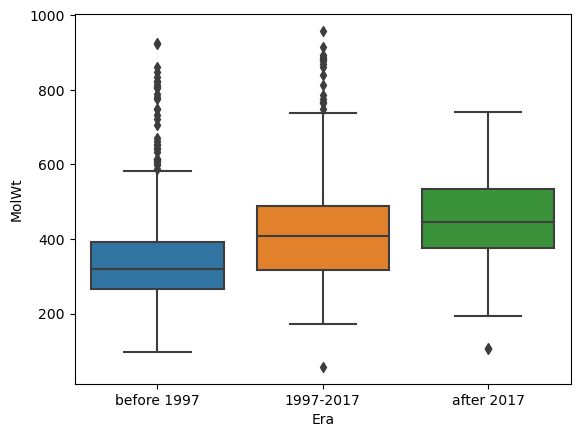

In [28]:
ax = sns.boxplot(x="era",y="MolWt",data=df_final_drug)
ax.set_xlabel("Era");

As mentioned above, we want to evaluate whether the molecular weight distribtions above are different.  When working with normally distributed data, we would use something like Student's t-test to compare two distributions.  Since the distributions we're dealing with are not normally distributed we'll use the non-parametric Wilcoxon Rank Sum Test.  We're dealing with three distribtions so we need to correct the p-value to account for multiple comparisons.  Fortuately for us, there's the **scikit-posthocs** Python package to do the heavy lifting.  For more on multiple comparsions and post-hoc tests, please see this Practical Cheminformatics blog post. Looking at the plot below, we see that we can invalidate the null hypothesis that the means of the distributions are the same with at least p < 0.01.  

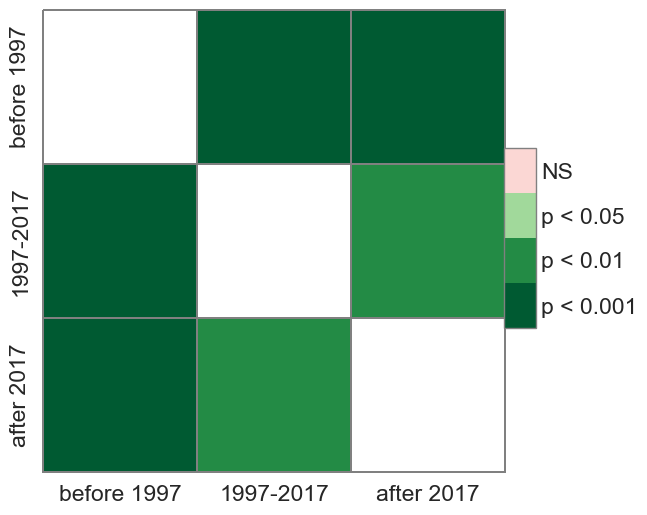

In [29]:
sns.set(rc={'figure.figsize':(8,6)},font_scale=1.5)
pc = sp.posthoc_mannwhitney(df_final_drug,val_col="MolWt",group_col="era",p_adjust='holm')
heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
_ = sp.sign_plot(pc, **heatmap_args)

Following the pattern above, we can look do the same analysis with the calculated LogP.  In this case, the two distributions on the right look similar.  Let's look at the statistics and see if they are different. 

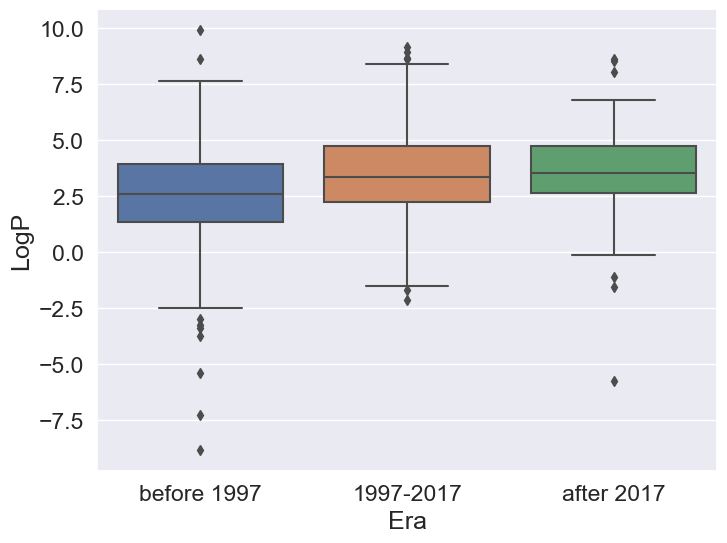

In [30]:
ax = sns.boxplot(x="era",y="LogP",data=df_final_drug)
ax.set_xlabel("Era");

Again, we'll use scikit-posthocs to create a heatmap.  In this case we can see that for "1997-2017" and "after 2017" sets, we cannot invalidate the null hypothesis that that distributions are the same. 

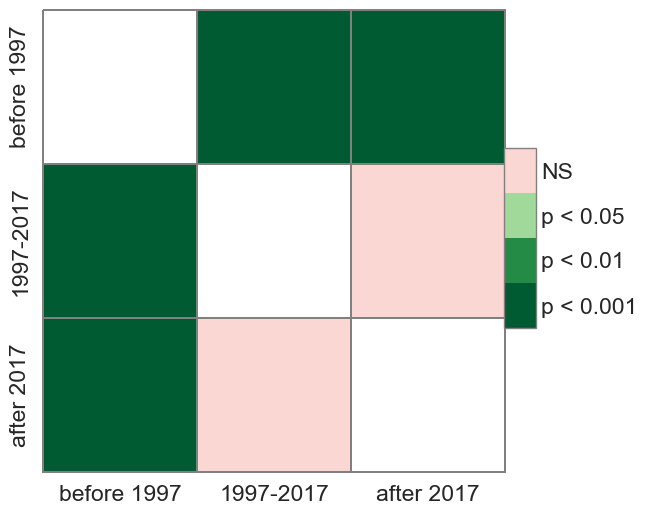

In [31]:
sns.set(rc={'figure.figsize':(8,6)},font_scale=1.5)
pc = sp.posthoc_mannwhitney(df_final_drug,val_col="LogP",group_col="era",p_adjust='holm')
heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
_ = sp.sign_plot(pc, **heatmap_args)

### Acknowledgements

I'd like to thank Emanuele Perola for motivating this notebook and Brian Kelley and Joann Prescott-Roy for useful discussions. 